In [99]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, losses, callbacks,\
                             regularizers
import random   
import PIL
import os
import time
import pathlib
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Input, Dense, Flatten, Reshape,\
                         MaxPooling2D, UpSampling2D, Conv2D, Lambda,\
                         GaussianNoise, LeakyReLU ,Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/content/drive/MyDrive/Group_Project_Data/Train
6000


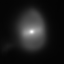

In [ ]:
train_data_dir = pathlib.Path('/content/drive/MyDrive/Group_Project_Data/Train')
valid_data_dir = pathlib.Path('/content/drive/MyDrive/Group_Project_Data/Valid')
print(train_data_dir)
image_count = len(list(train_data_dir.glob('*/*.png')))
print(image_count)
fake = list(train_data_dir.glob('Fake/*'))
(PIL.Image.open(str(fake[0])))

In [112]:
print('Loading data sets')
    
datagen = ImageDataGenerator(rescale=1./255,
 #                                horizontal_flip=True, vertical_flip=True,
                                 dtype='float32')
train_generator = datagen.flow_from_directory(train_data_dir, target_size=(64,64),
                                                  class_mode='binary',
                                              color_mode='grayscale',
                                                  batch_size=256,
                                                  shuffle=True)
valid_generator = datagen.flow_from_directory(valid_data_dir, target_size=(64,64),
                                                  class_mode='binary',
                                              color_mode='grayscale',
                                                  batch_size=256,
                                                  shuffle=True)

Loading data sets
Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [113]:
train_generator.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_generator = train_generator.cache().prefetch(buffer_size=AUTOTUNE)
valid_generator = valid_generator.cache().prefetch(buffer_size=AUTOTUNE)

AttributeError: ignored

In [ ]:
enc_in = layers.Input(shape=(64,64,1), dtype='float32')
flat = layers.Flatten()(enc_in)
D1 = layers.Dense(256, activation='relu', name='dense_1')(flat)
latent = layers.Dense(1, name='latents')(D1)

encoder = models.Model(inputs = enc_in, outputs = latent, name='encoder')
encoder.summary()

In [ ]:
dec_in = layers.Input(shape=(1,), dtype='float32')
D2 = layers.Dense(256, activation='relu', name='dense_2')(dec_in)
D3 = layers.Dense(4096, activation='relu', name='dense_3')(D2)
img_out = layers.Reshape((64,64,1), name='img_out')(D3)

decoder = models.Model(inputs = dec_in, outputs=img_out, name='decoder')
decoder.summary()

In [ ]:
autoencoder = models.Model(inputs = enc_in, outputs = decoder(encoder(enc_in)), name='autoencoder')
autoencoder.summary()

In [ ]:
autoencoder.compile(optimizer='Adam', loss='mse')

In [ ]:
history = autoencoder.fit(train_generator,validation_data=valid_generator,
  epochs=15,batch_size=256)

In [ ]:
img_height = 64
img_width = 64

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  #validation_split=0.2,
  #subset="training",
  seed=123,
  label_mode='binary',
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=200)


Found 6000 files belonging to 2 classes.


In [ ]:
train_ds.labels

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  valid_data_dir,
  #validation_split=0.2,
  #subset="validation",
  seed=123,
  label_mode='binary',
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=200)

Found 2000 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Fake', 'Real']


In [ ]:
#normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [111]:
# Initialize the model
model = Sequential()

# Layer 1: Convolutional layer with 32 filters, 3x3 kernel size, and ReLU activation
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1),dtype='float32'))
model.add(Conv2D(16, (3, 3),padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
# Layer 2: Max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
model.add(Conv2D(32, (3, 3),padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
model.add(Conv2D(32, (3, 3),padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
# Layer 4: Max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 5: Convolutional layer with 128 filters, 3x3 kernel size, and ReLU activation
model.add(Conv2D(64, (3, 3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
model.add(Conv2D(64, (3, 3),padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
# Layer 6: Max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
# Layer 7: Flatten layer to convert 2D features to 1D feature vector
model.add(Flatten())

# Layer 8: Fully connected layer with 256 units and ReLU activation
model.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))

model.add(Dropout(0.2))
# Layer 10: Output layer with the appropriate number of units for your task
model.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.0001)))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              #loss=tf.keras.losses.BinaryCrossentropy,
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 64, 64, 16)        160       
                                                                 
 conv2d_49 (Conv2D)          (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 conv2d_51 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                 

In [ ]:
enc_in = Input(shape=(64,64,1), dtype='float32', name='encoder_input')
Noise = GaussianNoise(1e-8)(enc_in)
Conv1 = Conv2D(64, kernel_size=(3,3),# activation='relu',
              padding='same', name='Conv1',
              kernel_regularizer=regularizers.l2(0.01),
              bias_regularizer=regularizers.l2(0.01),)(Noise) # (?, 128, 128, ?)
Conv1 = LeakyReLU(alpha=0.1)(Conv1)
Conv2 = Conv2D(64, kernel_size=(3,3),# activation='relu',
              padding='same', name='Conv2',
              kernel_regularizer=regularizers.l2(0.01),
              bias_regularizer=regularizers.l2(0.01),
              )(Conv1) # (?, 128, 128, ?)
Conv2 = LeakyReLU(alpha=0.1)(Conv2)
Pool1 = MaxPooling2D((2,2), name='Pool1')(Conv2) # (?, 64, 64, ?)
    
Conv3 = Conv2D(32, kernel_size=(5,5),# activation='relu',
                   padding='same', name='Conv3',
                   kernel_regularizer=regularizers.l2(0.01),
                   bias_regularizer=regularizers.l2(0.01),
                   )(Pool1) # (?, 64, 64, ?)
Conv3 = LeakyReLU(alpha=0.1)(Conv3)
Conv4 = Conv2D(32, kernel_size=(5,5),# activation='relu',
                   padding='same', name='Conv4',
                   kernel_regularizer=regularizers.l2(0.01),
                   bias_regularizer=regularizers.l2(0.01),
                   )(Conv3) # (?, 64, 64, 32)
Conv4 = LeakyReLU(alpha=0.1)(Conv4)
Pool2 = MaxPooling2D((2,2), name='Pool2')(Conv4) # (?, 32, 32, ?)
    
Conv5 = Conv2D(16, kernel_size=(5,5),# activation='relu',
                   padding='same', name='Conv5',
                   kernel_regularizer=regularizers.l2(0.01),
                   bias_regularizer=regularizers.l2(0.01),
                   )(Pool2) # (?, 32, 32, ?)
Conv5 = LeakyReLU(alpha=0.1)(Conv5)
Conv6 = Conv2D(16, kernel_size=(5,5),# activation='relu',
                   padding='same', name='Conv6',
                   kernel_regularizer=regularizers.l2(0.01),
                   bias_regularizer=regularizers.l2(0.01),
                   )(Conv5) # (?, 32, 32, ?)
Conv6 = LeakyReLU(alpha=0.1)(Conv6)
Pool3 = MaxPooling2D((2,2), name='Pool3')(Conv6) # (?, 16, 16, ?)
    
enc_out = Flatten(name='Flat')(Pool3) # (?, 16*16*?)
D1 = layers.Dense(128, activation='relu', name='dense_1')(enc_out)
latent = layers.Dense(20, name='latents')(D1)
encoder = models.Model(inputs = enc_in, outputs = latent, name='encoder')
encoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 64, 64, 1)]       0         
                                                                 
 gaussian_noise_4 (GaussianN  (None, 64, 64, 1)        0         
 oise)                                                           
                                                                 
 Conv1 (Conv2D)              (None, 64, 64, 64)        640       
                                                                 
 leaky_re_lu_66 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 Conv2 (Conv2D)              (None, 64, 64, 64)        36928     
                                                                 
 leaky_re_lu_67 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                           

In [ ]:
def VAE_sampling(args):

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
#z_mean = Dense(20, name='latentmean',
#                   kernel_regularizer=regularizers.l2(0.01),
#                   bias_regularizer=regularizers.l2(0.01),
#                   )(enc_out) # Edit namespace for CAE
#z_log_var = Dense(20, name='latentlog_var',
#                   kernel_regularizer=regularizers.l2(0.01),
 #                  bias_regularizer=regularizers.l2(0.01),
 #                  )(enc_out) # Comment out for CAE

#z = Lambda(VAE_sampling, output_shape=(20,),
#               name='latentz_sampling')([z_mean,z_log_var]) # repara trick
                 
#y_training = K.variable(False, dtype='bool')
#z_out = Lambda(cond_z(y_training), output_shape=(20,),
#                   name='conditional_z_out')([z_mean, z]) # set input for decoder
    
#GMM = GMMLayer(20, 12, name='latentGMM_Layer')
#z_out = GMM(z_out) # pass through layer containing GMM weights
    
#gmm_weights = { 'theta' : GMM.weights[0],
#                    'mu' : GMM.weights[1],
#                    'lambda' : GMM.weights[2],}
#gamma_out, z_out = get_gamma(gmm_weights, params)(z_out)
    
#outputs = { 'z' : z,
#                'z_mean' : z_mean,
#                'z_log_var' : z_log_var,
#                'z_out' : z_out,
#                'gamma' : gamma_out,}

    
dec_in = Input(shape=(20,), dtype='float32', name='decoder_input')

FC3 = Dense(4096, name='FC3',
                   kernel_regularizer=regularizers.l2(0.01),
                   bias_regularizer=regularizers.l2(0.01))(dec_in) # (?, 16*16*?)
FC3 = LeakyReLU(alpha=0.1)(FC3)
reshape = Reshape((16,16,16), name='reshape')(FC3) # (?, 16, 16, ?)
    
Conv7 = Conv2D(16, kernel_size=(5,5),# activation='relu',
                   padding='same', name='Conv7',
                   kernel_regularizer=regularizers.l2(0.01),
                   bias_regularizer=regularizers.l2(0.01),
                   )(reshape) # (?, 16, 16, ?) 
Conv7 = LeakyReLU(alpha=0.1)(Conv7)
Conv8 = Conv2D(16, kernel_size=(5,5),# activation='relu',
                   padding='same', name='Conv8',
                   kernel_regularizer=regularizers.l2(0.01),
                   bias_regularizer=regularizers.l2(0.01),
                   )(Conv7) # (?, 16, 16, ?) 
Conv8 = LeakyReLU(alpha=0.1)(Conv8)
Up1 = UpSampling2D((2,2), interpolation='bilinear',
                       name='Up1')(Conv8) # (?, 32, 32, ?)
    
Conv9 = Conv2D(32, kernel_size=(5,5),# activation='relu',
                   padding='same', name='Conv9',
                   kernel_regularizer=regularizers.l2(0.01),
                   bias_regularizer=regularizers.l2(0.01),
                   )(Up1) # (?, 32, 32, ?) 
Conv9 = LeakyReLU(alpha=0.1)(Conv9)
Conv10 = Conv2D(32, kernel_size=(5,5),# activation='relu',
                   padding='same', name='Conv10',
                   kernel_regularizer=regularizers.l2(0.01),
                   bias_regularizer=regularizers.l2(0.01),
                   )(Conv9) # (?, 32, 32, ?) 
Conv10 = LeakyReLU(alpha=0.1)(Conv10)
Up2 = UpSampling2D((2,2), interpolation='bilinear',
                       name='Up2')(Conv10) # (?, 64, 64, ?)
    
Conv11 = Conv2D(64, kernel_size=(5,5),# activation='relu',
                   padding='same', name='Conv11',
                   kernel_regularizer=regularizers.l2(0.01),
                   bias_regularizer=regularizers.l2(0.01),
                   )(Up2) # (?, 64, 64, ?) 
Conv11 = LeakyReLU(alpha=0.1)(Conv11)
Conv12 = Conv2D(64, kernel_size=(5,5),# activation='relu',
                   padding='same', name='Conv12',
                   kernel_regularizer=regularizers.l2(0.01),
                   bias_regularizer=regularizers.l2(0.01),
                   )(Conv11) # (?, 64, 64, ?) 
Conv12 = LeakyReLU(alpha=0.1)(Conv12)
#Up3 = UpSampling2D((2,2), #interpolation='bilinear',
#                       name='Up3')(Conv12) # (?, 128, 128, ?)
    
Out = Conv2D(1, kernel_size=(5,5), activation='relu',
                 padding='same', name='Output',
                 kernel_regularizer=regularizers.l2(0.01),
                 bias_regularizer=regularizers.l2(0.01),
                 )(Conv12) # (?, 128, 128, b)
decoder = models.Model(inputs = dec_in, outputs=Out, name='decoder')    
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 20)]              0         
                                                                 
 FC3 (Dense)                 (None, 4096)              86016     
                                                                 
 leaky_re_lu_79 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 16)        0         
                                                                 
 Conv7 (Conv2D)              (None, 16, 16, 16)        6416      
                                                                 
 leaky_re_lu_80 (LeakyReLU)  (None, 16, 16, 16)        0         
                                                                 
 Conv8 (Conv2D)              (None, 16, 16, 16)        6416

In [102]:
autoencoder = models.Model(inputs = enc_in, outputs = decoder(encoder(enc_in)), name='autoencoder')
autoencoder.summary()
#autoencoder = models.Model(inputs = enc_in, outputs = Out, name='autoencoder')
#autoencoder.summary()
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 64, 64, 1)]       0         
                                                                 
 encoder (Functional)        (None, 20)                267444    
                                                                 
 decoder (Functional)        (None, 64, 64, 1)         292641    
                                                                 
Total params: 560,085
Trainable params: 560,085
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_generator,validation_data=valid_generator,
  epochs=15,batch_size=256)

Epoch 1/15
24/24 [==============================] - 19s 628ms/step - loss: 0.4589 - accuracy: 0.7692 - val_loss: 0.0503 - val_accuracy: 0.9915
Epoch 2/15
24/24 [==============================] - 14s 610ms/step - loss: 0.0910 - accuracy: 0.9815 - val_loss: 0.2978 - val_accuracy: 0.8865
Epoch 3/15
24/24 [==============================] - 14s 588ms/step - loss: 0.1113 - accuracy: 0.9677 - val_loss: 0.0473 - val_accuracy: 0.9935
Epoch 4/15
24/24 [==============================] - 14s 575ms/step - loss: 0.0318 - accuracy: 0.9970 - val_loss: 0.0328 - val_accuracy: 0.9955
Epoch 5/15
24/24 [==============================] - 14s 567ms/step - loss: 0.0238 - accuracy: 0.9992 - val_loss: 0.0317 - val_accuracy: 0.9960
Epoch 6/15
24/24 [==============================] - 14s 576ms/step - loss: 0.0218 - accuracy: 0.9997 - val_loss: 0.0314 - val_accuracy: 0.9970
Epoch 7/15
24/24 [==============================] - 14s 566ms/step - loss: 0.0220 - accuracy: 0.9997 - val_loss: 0.0312 - val_accuracy: 0.9970

7/7 [==============================] - 0s 3ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


TypeError: ignored

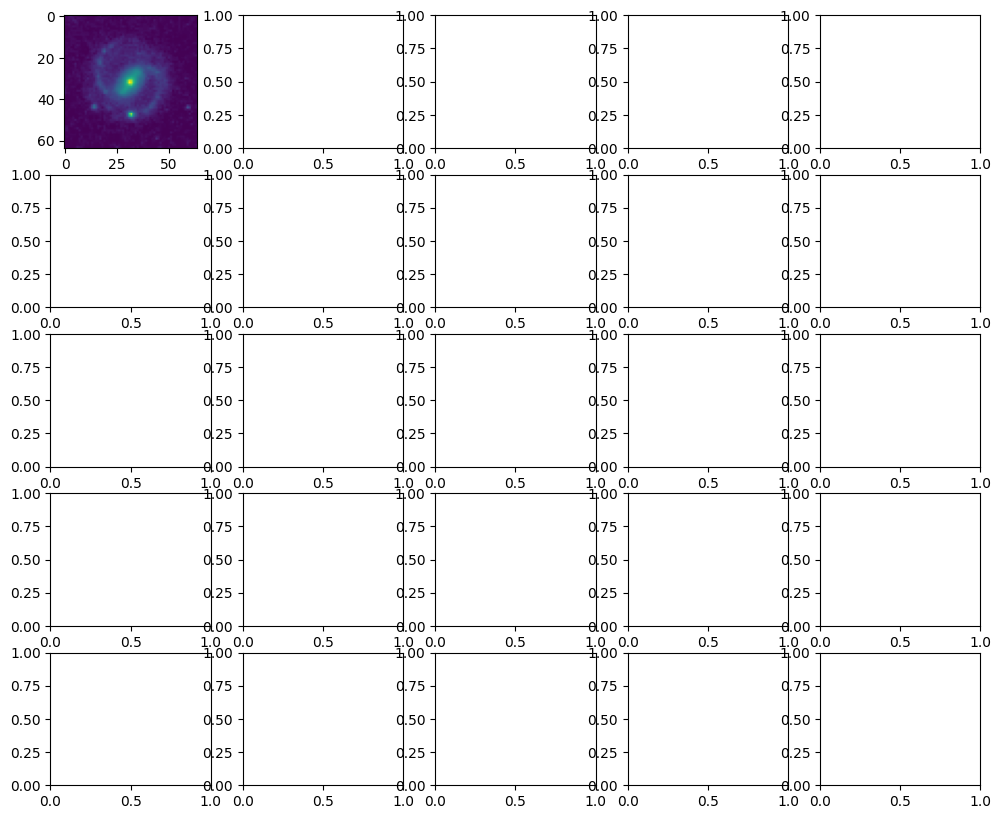

In [106]:
f, ax = plt.subplots(5, 5, figsize=(12, 10))
ax = ax.flatten()

for images, labels in val_ds.take(1):
    # Get model predictions
    y_pred = model.predict(images)
    y_pred_label = np.argmax(y_pred, axis=1)
    print(y_pred_label)
  
    for i in range(25):
        ax[i].imshow(images[i].numpy().astype("float32"))
        ax[i].set_title(f"truth {class_names[labels[i]]}  pred {class_names[y_pred_label[i]]}")
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
f.tight_layout()
plt.show()

In [ ]:
y_pred = autoencoder.predict(val_ds)
y_pred_label = np.argmax(y_pred, axis=-1)
print(len(y_pred_label))
y_pred_label

In [ ]:
autoencoder.evaluate(val_ds)
test_loss, test_acc = autoencoder.evaluate(val_ds)
print(test_acc)
print(test_loss)

In [ ]:
f , ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(history.history['loss'], label='Train_data')
ax[0].plot(history.history['val_loss'], label='Validation_data')
ax[0].legend(loc=0)
ax[0].set_title("model loss")

ax[1].plot(history.history['accuracy'], label='Train_data')
ax[1].plot(history.history['val_accuracy'], label='Validation_data')
ax[1].legend(loc=0)
ax[1].set_title('Model Accuracy')

plt.show()

y_pred = model.predict(val_ds)
y_pred_label = np.argmax(y_pred, axis=-1)
len(y_pred)



